In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/task3/train.csv")

In [72]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, explorative = True)
profile.to_file("Task3ProfileReport.html")

## Add "is_spending" Features

In [74]:
df["is_spending"] = df["spending_30d"] != 0

## Modeling "is_spending" Layer

In [75]:
from xgboost import XGBClassifier, DMatrix, train as xgb_train

X = df.drop(columns = ["spending_30d", "is_spending", "id", "player_id"])
y_class = df["is_spending"]

from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size = 0.2, random_state = 42, stratify = y_class
)

In [76]:
Classifier = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    use_label_encoder = False
)

Classifier.fit(X_train_c, y_train_c)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Evaluation for Classification Layer

In [77]:
pred_is_spender = Classifier.predict(X)  # True/False
df["pred_is_spender"] = pred_is_spender

In [78]:
df["is_spending"] = df["is_spending"].astype(int)

In [79]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df["is_spending"], df["pred_is_spender"])
print(f"First Layer Accuracy (is_spending): {accuracy:.4f}")

First Layer Accuracy (is_spending): 0.7765


## Modeling "spending_30d" Layer

In [80]:
df_reg = df[df["pred_is_spender"] == True].copy()

X_reg = df_reg.drop(columns = ["spending_30d", "is_spending", "pred_is_spender", "id", "player_id"])
y_reg = df_reg["spending_30d"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size = 0.2, random_state = 42
)

dmatrix_train = DMatrix(X_train_r, label = y_train_r, missing = np.nan)
dmatrix_test = DMatrix(X_test_r, label = y_test_r, missing = np.nan)

In [81]:
from xgboost import XGBRegressor

reg_model = XGBRegressor(
    objective = "reg:squarederror",
    eval_metric = "rmse"
)

In [82]:
reg_model.fit(X_train_r, y_train_r)

pred_spending = reg_model.predict(X_test_r)

In [83]:
pred_spending

array([ -409.98544,  1756.805  ,   805.6208 , ...,  2279.0244 ,
        1912.8524 , -1202.5962 ], dtype=float32)

## Evaluation for Regression Layer

In [84]:
from sklearn.metrics import mean_absolute_error

final_pred_spending = np.zeros(len(df))

spender_idx = np.where(df["pred_is_spender"] == True)[0]
X_reg = df.drop(columns = ["spending_30d", "is_spending", "pred_is_spender", "id", "player_id"]).iloc[spender_idx]

final_pred_spending[spender_idx] = reg_model.predict(X_reg)

y_true = df["spending_30d"].values

In [85]:
mae = mean_absolute_error(y_true, final_pred_spending)
print(f"Final MAE (with non-spenders as 0): {mae:.4f}")

Final MAE (with non-spenders as 0): 2149.8484


In [86]:
final_pred_all_103 = np.full(len(df), 103.0)

mae_all_103 = mean_absolute_error(y_true, final_pred_all_103)
print(f"MAE when predicting 103 for all records: {mae_all_103:.4f}")

MAE when predicting 103 for all records: 10368.3987


# StackEnsemble


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/task3/train.csv")
df.drop(columns=["id", "player_id"], inplace = True)

df["is_spending"] = (df["spending_30d"] != 0).astype(int)

FEATURE_COLS = [c for c in df.columns if c not in ("spending_30d", "is_spending")]

X = df[FEATURE_COLS]
y_cls = df["is_spending"]
y_reg = df["spending_30d"]

## Feature Importance

In [6]:
from xgboost import XGBClassifier, XGBRegressor

xgb_cls = XGBClassifier(objective = "binary:logistic", use_label_encoder = False,
                        eval_metric = "logloss", random_state = 42, n_jobs = -1, verbosity = 0)
xgb_cls.fit(X, y_cls)

booster_clf = xgb_cls.get_booster()
fi_clf = booster_clf.get_score(importance_type = "gain")

def map_xgb_feature_names(fi_dict, columns):
    mapped = {}
    for k, v in fi_dict.items():
        if k.startswith("f") and k[1:].isdigit():
            idx = int(k[1:])
            mapped_name = columns[idx]
            mapped[mapped_name] = v
        else:
            if k in columns:
                mapped[k] = v
            else:
                pass
    return mapped


fi_clf_mapped = map_xgb_feature_names(fi_clf, X.columns)
fi_clf_df = pd.DataFrame(list(fi_clf_mapped.items()), columns = ["feature", "importance"])

xgb_reg = XGBRegressor(objective = "reg:absoluteerror", random_state = 42, n_jobs = -1, verbosity = 0)
xgb_reg.fit(X, y_reg)

booster_reg = xgb_reg.get_booster()
fi_reg = booster_reg.get_score(importance_type = "gain")

fi_reg_mapped = map_xgb_feature_names(fi_reg, X.columns)
fi_reg_df = pd.DataFrame(list(fi_reg_mapped.items()), columns = ["feature", "importance"])

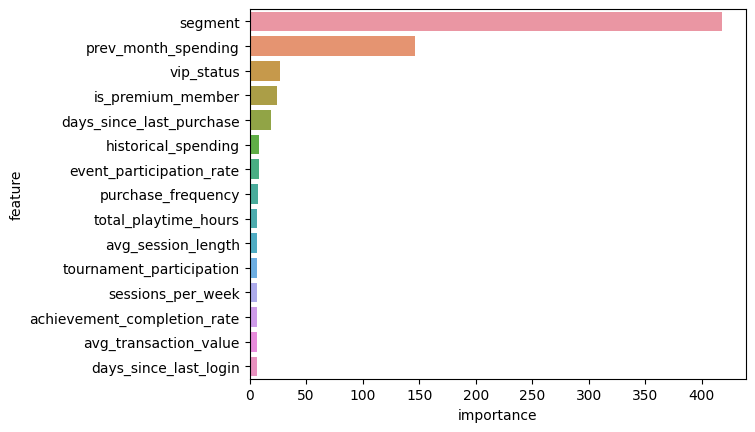

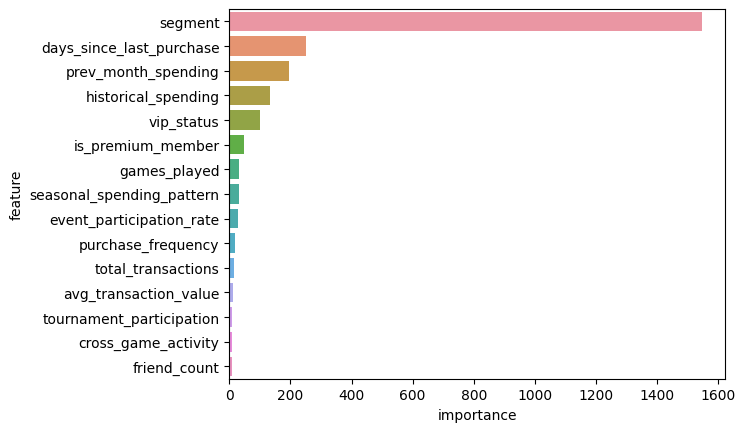

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fi_clf_df = fi_clf_df.sort_values("importance", ascending = False).reset_index(drop = True)
Top15_clf = fi_clf_df.head(15)

sns.barplot(data = Top15_clf, y = "feature", x = "importance", orient = "h")
plt.show()

fi_reg_df = fi_reg_df.sort_values("importance", ascending = False).reset_index(drop = True)
Top15_reg = fi_reg_df.head(15)

sns.barplot(data = Top15_reg, y = "feature", x = "importance", orient = "h")
plt.show()

In [8]:
fi_clf_df["cumulative_importance"] = fi_clf_df["importance"].cumsum() / fi_clf_df["importance"].sum()
selected_features_clf = list(fi_clf_df[fi_clf_df["cumulative_importance"] <= 0.90]["feature"])

fi_reg_df["cumulative_importance"] = fi_reg_df["importance"].cumsum() / fi_reg_df["importance"].sum()
selected_features_reg = list(fi_reg_df[fi_reg_df["cumulative_importance"] <= 0.90]["feature"])

selected_union = sorted(set(selected_features_clf) | set(selected_features_reg))
print(f"Selected {len(selected_union)} features out of {X.shape[1]} total features")

X_selected = X[selected_union].copy()

Selected 19 features out of 32 total features


## Modeling

In [9]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_absolute_error
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor

clf = CatBoostClassifier(random_state = 42, verbose = 0, thread_count = 1)

estimators = [
    ("xgb", XGBRegressor(objective = "reg:absoluteerror", random_state = 42, n_jobs = 1, verbosity = 0)),
    ("lgbm", LGBMRegressor(objective = "mae", random_state = 42, n_jobs = 1)),
    ("cat", CatBoostRegressor(loss_function = "MAE", random_state = 42, verbose = 0, thread_count = 1)),
]

blender = ElasticNet(alpha = 0.05, l1_ratio = 0.5, max_iter = 5000, random_state = 42)

stack = StackingRegressor(
    estimators = estimators,
    final_estimator = blender,
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

In [10]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_selected, y_reg), start = 1):
    X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    y_cls_train, y_cls_val = y_cls.iloc[train_idx], y_cls.iloc[val_idx]
    y_reg_train, y_reg_val = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

    clf.fit(X_train, y_cls_train)

    # Mask only positive spenders
    pos_mask = y_reg_train > 0

    X_reg_train = X_train[pos_mask]
    y_reg_train_pos = y_reg_train[pos_mask]

    # fit stacking regressor on positive examples
    stack.fit(X_reg_train, y_reg_train_pos)

    # predictions on val:
    # classifier predicts labels (0/1).
    y_cls_pred = clf.predict(X_val)

    # initialize final preds to zeros
    y_pred_final = np.zeros(len(X_val), dtype = float)

    # indexes where classifier predicted spender == 1
    probs = clf.predict_proba(X_val)[:,1]
    positive_idx = np.where(probs >= 0.5)[0]
    if positive_idx.size > 0:
        X_val_pos = X_val.iloc[positive_idx]
        y_pos_pred = stack.predict(X_val_pos)
        # clip to >= 0
        y_pos_pred = np.clip(y_pos_pred, a_min = 0, a_max = None)
        y_pred_final[positive_idx] = y_pos_pred

    # compute MAE on this fold (compare to true y_reg_val)
    mae = mean_absolute_error(y_reg_val.values, y_pred_final)
    mae_scores.append(mae)
    print(f"Fold {fold} MAE = {mae:.6f}")

print(f"CV MAE (mean ± std): {np.mean(mae_scores):.6f} ± {np.std(mae_scores):.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34478, number of used features: 19
[LightGBM] [Info] Start training from score 2307.334961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34478, number of used features: 19
[LightGBM] [Info] Start training from score 2314.489990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

## Hyperparameter

In [14]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective_clf(trial):
    params = {
        "iterations": trial.suggest_int("clf_iterations", 100, 1000),
        "depth": trial.suggest_int("clf_depth", 3, 10),
        "learning_rate": trial.suggest_float("clf_lr", 0.01, 0.3, log = True),
        "l2_leaf_reg": trial.suggest_float("clf_l2", 1e-3, 10, log = True),
        "loss_function": "Logloss",
        "verbose": 0,
        "thread_count": 1,
        "random_state": 42
    }

    clf = CatBoostClassifier(**params)

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(clf, X_selected, y_cls, cv = cv, scoring = "f1", n_jobs = -1)
    
    return 1.0 - scores.mean()

study_clf = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_clf.optimize(objective_clf, n_trials = 30)

print("Best CatBoostClassifier params:", study_clf.best_params)
print("Best CV F1:", 1.0 - study_clf.best_value)

[I 2025-11-15 19:41:13,689] A new study created in memory with name: no-name-e7f6893c-af61-40b3-b85f-3176a6f3e8df
[I 2025-11-15 19:43:30,306] Trial 0 finished with value: 0.29522031652478053 and parameters: {'clf_iterations': 437, 'clf_depth': 10, 'clf_lr': 0.1205712628744377, 'clf_l2': 0.24810409748678125}. Best is trial 0 with value: 0.29522031652478053.
[I 2025-11-15 19:43:44,985] Trial 1 finished with value: 0.27808242558998275 and parameters: {'clf_iterations': 240, 'clf_depth': 4, 'clf_lr': 0.012184186502221764, 'clf_l2': 2.9154431891537547}. Best is trial 1 with value: 0.27808242558998275.
[I 2025-11-15 19:45:07,151] Trial 2 finished with value: 0.2760370265987283 and parameters: {'clf_iterations': 641, 'clf_depth': 8, 'clf_lr': 0.010725209743171997, 'clf_l2': 7.579479953348009}. Best is trial 2 with value: 0.2760370265987283.
[I 2025-11-15 19:45:54,698] Trial 3 finished with value: 0.27655856533545875 and parameters: {'clf_iterations': 850, 'clf_depth': 4, 'clf_lr': 0.018559980

Best CatBoostClassifier params: {'clf_iterations': 667, 'clf_depth': 6, 'clf_lr': 0.016432288615186925, 'clf_l2': 4.066032406622472}
Best CV F1: 0.7240780174980797


In [15]:
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("xgb_n_estimators", 50, 500),
        "max_depth": trial.suggest_int("xgb_max_depth", 3, 10),
        "learning_rate": trial.suggest_float("xgb_lr", 0.03, 0.3),
        "subsample": trial.suggest_float("xgb_subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("xgb_colsample", 0.4, 1.0),
        "objective": "reg:absoluteerror",
        "random_state": 42,
        "n_jobs": 1
    }
    model = XGBRegressor(**params)
    
    pos_mask = y_reg > 0
    X_pos, y_pos = X_selected[pos_mask], y_reg[pos_mask]
    
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = []
    for train_idx, val_idx in kf.split(X_pos):
        X_train, X_val = X_pos.iloc[train_idx], X_pos.iloc[val_idx]
        y_train, y_val = y_pos.iloc[train_idx], y_pos.iloc[val_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred = np.clip(y_pred, 0, None)
        scores.append(mean_absolute_error(y_val, y_pred))
    return np.mean(scores)

study_xgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_xgb.optimize(objective_xgb, n_trials = 30)
print("Best XGBRegressor params:", study_xgb.best_params)

[I 2025-11-15 20:15:11,910] A new study created in memory with name: no-name-f5ad0c93-9c53-408a-b75f-dd8610b8ed01
[I 2025-11-15 20:16:05,325] Trial 0 finished with value: 4382.113042275463 and parameters: {'xgb_n_estimators': 218, 'xgb_max_depth': 10, 'xgb_lr': 0.22763836428907938, 'xgb_subsample': 0.8394633936788146, 'xgb_colsample': 0.4936111842654619}. Best is trial 0 with value: 4382.113042275463.
[I 2025-11-15 20:16:15,239] Trial 1 finished with value: 4106.044833387254 and parameters: {'xgb_n_estimators': 120, 'xgb_max_depth': 3, 'xgb_lr': 0.2638675593592325, 'xgb_subsample': 0.8404460046972835, 'xgb_colsample': 0.8248435466776274}. Best is trial 1 with value: 4106.044833387254.
[I 2025-11-15 20:16:31,752] Trial 2 finished with value: 4368.0689786762105 and parameters: {'xgb_n_estimators': 59, 'xgb_max_depth': 10, 'xgb_lr': 0.2547595130161139, 'xgb_subsample': 0.6849356442713105, 'xgb_colsample': 0.5090949803242604}. Best is trial 1 with value: 4106.044833387254.
[I 2025-11-15 20

Best XGBRegressor params: {'xgb_n_estimators': 442, 'xgb_max_depth': 7, 'xgb_lr': 0.03191487162596225, 'xgb_subsample': 0.9922659653438526, 'xgb_colsample': 0.9890115480808084}


In [16]:
def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("lgb_n_estimators", 50, 500),
        "max_depth": trial.suggest_int("lgb_max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 20, 128),
        "learning_rate": trial.suggest_float("lgb_lr", 0.03, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "objective": "mae",
        "random_state": 42,
        "n_jobs": 1
    }
    model = LGBMRegressor(**params)
    
    pos_mask = y_reg > 0
    X_pos, y_pos = X_selected[pos_mask], y_reg[pos_mask]

    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = []
    for train_idx, val_idx in kf.split(X_pos):
        X_train, X_val = X_pos.iloc[train_idx], X_pos.iloc[val_idx]
        y_train, y_val = y_pos.iloc[train_idx], y_pos.iloc[val_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred = np.clip(y_pred, 0, None)
        scores.append(mean_absolute_error(y_val, y_pred))
    return np.mean(scores)

study_lgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_lgb.optimize(objective_lgb, n_trials = 30)
print("Best LGBMRegressor params:", study_lgb.best_params)

[I 2025-11-15 20:39:38,025] A new study created in memory with name: no-name-ac159a82-8fb6-4287-b320-a7e349f85e43


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Info] Auto-choosing 

[I 2025-11-15 20:39:54,123] Trial 0 finished with value: 3870.447201530522 and parameters: {'lgb_n_estimators': 218, 'lgb_max_depth': 12, 'num_leaves': 99, 'lgb_lr': 0.1916377907331999, 'subsample': 0.5780093202212182}. Best is trial 0 with value: 3870.447201530522.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:39:57,990] Trial 1 finished with value: 4130.093959846713 and parameters: {'lgb_n_estimators': 120, 'lgb_max_depth': 3, 'num_leaves': 114, 'lgb_lr': 0.1923010531706664, 'subsample': 0.8540362888980227}. Best is trial 0 with value: 3870.447201530522.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 20:40:05,078] Trial 2 finished with value: 3898.4578527714352 and parameters: {'lgb_n_estimators': 59, 'lgb_max_depth': 12, 'num_leaves': 110, 'lgb_lr': 0.08733155988313457, 'subsample': 0.5909124836035503}. Best is trial 0 with value: 3870.447201530522.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:40:12,280] Trial 3 finished with value: 3837.1405267626033 and parameters: {'lgb_n_estimators': 132, 'lgb_max_depth': 6, 'num_leaves': 77, 'lgb_lr': 0.14662515503337126, 'subsample': 0.645614570099021}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 229

[I 2025-11-15 20:40:22,420] Trial 4 finished with value: 3846.5400975235652 and parameters: {'lgb_n_estimators': 325, 'lgb_max_depth': 4, 'num_leaves': 51, 'lgb_lr': 0.12891769768929678, 'subsample': 0.728034992108518}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:40:34,397] Trial 5 finished with value: 3856.630486293019 and parameters: {'lgb_n_estimators': 404, 'lgb_max_depth': 4, 'num_leaves': 76, 'lgb_lr': 0.18995193359275148, 'subsample': 0.5232252063599989}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:40:44,246] Trial 6 finished with value: 3919.6072358749443 and parameters: {'lgb_n_estimators': 324, 'lgb_max_depth': 4, 'num_leaves': 27, 'lgb_lr': 0.2861990950584, 'subsample': 0.9828160165372797}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:40:59,506] Trial 7 finished with value: 3881.4727643887404 and parameters: {'lgb_n_estimators': 414, 'lgb_max_depth': 6, 'num_leaves': 30, 'lgb_lr': 0.21474291715828236, 'subsample': 0.7200762468698007}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-11-15 20:41:04,044] Trial 8 finished with value: 3951.271824956555 and parameters: {'lgb_n_estimators': 105, 'lgb_max_depth': 7, 'num_leaves': 23, 'lgb_lr': 0.2755165085612712, 'subsample': 0.6293899908000085}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:41:19,868] Trial 9 finished with value: 3850.0512226534493 and parameters: {'lgb_n_estimators': 348, 'lgb_max_depth': 6, 'num_leaves': 76, 'lgb_lr': 0.17761177542268552, 'subsample': 0.5924272277627636}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the tra

[I 2025-11-15 20:41:35,669] Trial 10 finished with value: 3850.9643142900654 and parameters: {'lgb_n_estimators': 214, 'lgb_max_depth': 9, 'num_leaves': 55, 'lgb_lr': 0.0348497064160013, 'subsample': 0.8285618345363206}. Best is trial 3 with value: 3837.1405267626033.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004100 seconds.
You

[I 2025-11-15 20:41:49,097] Trial 11 finished with value: 3831.132242698773 and parameters: {'lgb_n_estimators': 244, 'lgb_max_depth': 9, 'num_leaves': 55, 'lgb_lr': 0.11956095892913117, 'subsample': 0.7379475142683847}. Best is trial 11 with value: 3831.132242698773.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003958 seconds.
You

[I 2025-11-15 20:42:00,270] Trial 12 finished with value: 3827.336903137184 and parameters: {'lgb_n_estimators': 192, 'lgb_max_depth': 9, 'num_leaves': 56, 'lgb_lr': 0.12682586006553867, 'subsample': 0.6735453401138016}. Best is trial 12 with value: 3827.336903137184.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003778 seconds.
You

[I 2025-11-15 20:42:12,649] Trial 13 finished with value: 3834.1121339867364 and parameters: {'lgb_n_estimators': 217, 'lgb_max_depth': 10, 'num_leaves': 53, 'lgb_lr': 0.09993269352607699, 'subsample': 0.8153802215852831}. Best is trial 12 with value: 3827.336903137184.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-11-15 20:42:27,213] Trial 14 finished with value: 3831.700384135166 and parameters: {'lgb_n_estimators': 260, 'lgb_max_depth': 9, 'num_leaves': 41, 'lgb_lr': 0.053319608891203046, 'subsample': 0.69256508270891}. Best is trial 12 with value: 3827.336903137184.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-11-15 20:43:00,242] Trial 15 finished with value: 3805.798718677109 and parameters: {'lgb_n_estimators': 485, 'lgb_max_depth': 10, 'num_leaves': 91, 'lgb_lr': 0.11075423676381985, 'subsample': 0.9420165091088306}. Best is trial 15 with value: 3805.798718677109.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Warning] 

[I 2025-11-15 20:43:34,813] Trial 16 finished with value: 3798.748158588839 and parameters: {'lgb_n_estimators': 500, 'lgb_max_depth': 11, 'num_leaves': 89, 'lgb_lr': 0.0784633109126073, 'subsample': 0.9976025610078831}. Best is trial 16 with value: 3798.748158588839.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

[I 2025-11-15 20:44:09,909] Trial 17 finished with value: 3799.437787450663 and parameters: {'lgb_n_estimators': 500, 'lgb_max_depth': 11, 'num_leaves': 95, 'lgb_lr': 0.07613726295411502, 'subsample': 0.9980084946806067}. Best is trial 16 with value: 3798.748158588839.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:44:52,276] Trial 18 finished with value: 3794.726296008544 and parameters: {'lgb_n_estimators': 500, 'lgb_max_depth': 11, 'num_leaves': 122, 'lgb_lr': 0.06858968024851353, 'subsample': 0.910236126593346}. Best is trial 18 with value: 3794.726296008544.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:45:29,696] Trial 19 finished with value: 3789.4164489214754 and parameters: {'lgb_n_estimators': 436, 'lgb_max_depth': 11, 'num_leaves': 125, 'lgb_lr': 0.0645125675563128, 'subsample': 0.9072950643400716}. Best is trial 19 with value: 3789.4164489214754.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:46:09,188] Trial 20 finished with value: 3769.3870102669825 and parameters: {'lgb_n_estimators': 432, 'lgb_max_depth': 11, 'num_leaves': 128, 'lgb_lr': 0.04566278434624883, 'subsample': 0.9050218665833651}. Best is trial 20 with value: 3769.3870102669825.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:46:50,729] Trial 21 finished with value: 3778.5636860350232 and parameters: {'lgb_n_estimators': 428, 'lgb_max_depth': 11, 'num_leaves': 128, 'lgb_lr': 0.031101277812843373, 'subsample': 0.9019568396062796}. Best is trial 20 with value: 3769.3870102669825.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:47:31,365] Trial 22 finished with value: 3770.582217394132 and parameters: {'lgb_n_estimators': 411, 'lgb_max_depth': 12, 'num_leaves': 126, 'lgb_lr': 0.032512077617908725, 'subsample': 0.8850803398675819}. Best is trial 20 with value: 3769.3870102669825.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003827 seconds.
You

[I 2025-11-15 20:48:05,856] Trial 23 finished with value: 3765.590600418536 and parameters: {'lgb_n_estimators': 381, 'lgb_max_depth': 12, 'num_leaves': 111, 'lgb_lr': 0.03460899477047702, 'subsample': 0.8574993409198984}. Best is trial 23 with value: 3765.590600418536.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003882 seconds.
You

[I 2025-11-15 20:48:37,841] Trial 24 finished with value: 3771.731458522917 and parameters: {'lgb_n_estimators': 356, 'lgb_max_depth': 12, 'num_leaves': 115, 'lgb_lr': 0.0480809250661194, 'subsample': 0.7881018569659317}. Best is trial 23 with value: 3765.590600418536.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003782 seconds.
You

[I 2025-11-15 20:49:12,299] Trial 25 finished with value: 3781.9971923837156 and parameters: {'lgb_n_estimators': 384, 'lgb_max_depth': 12, 'num_leaves': 103, 'lgb_lr': 0.030759428998046526, 'subsample': 0.8579204672181263}. Best is trial 23 with value: 3765.590600418536.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:49:44,985] Trial 26 finished with value: 3939.330143896344 and parameters: {'lgb_n_estimators': 446, 'lgb_max_depth': 10, 'num_leaves': 106, 'lgb_lr': 0.250464522362845, 'subsample': 0.7780575984770369}. Best is trial 23 with value: 3765.590600418536.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-11-15 20:50:07,428] Trial 27 finished with value: 3785.696966095551 and parameters: {'lgb_n_estimators': 299, 'lgb_max_depth': 8, 'num_leaves': 119, 'lgb_lr': 0.05440176730694969, 'subsample': 0.8729319197613544}. Best is trial 23 with value: 3765.590600418536.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of dat

[I 2025-11-15 20:50:45,992] Trial 28 finished with value: 3811.321672426384 and parameters: {'lgb_n_estimators': 457, 'lgb_max_depth': 12, 'num_leaves': 128, 'lgb_lr': 0.09253021191662561, 'subsample': 0.9371313658083721}. Best is trial 23 with value: 3765.590600418536.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2293.379883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2302.125000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003789 seconds.
You

[I 2025-11-15 20:51:09,894] Trial 29 finished with value: 3849.7724991877644 and parameters: {'lgb_n_estimators': 375, 'lgb_max_depth': 12, 'num_leaves': 85, 'lgb_lr': 0.15052766596144623, 'subsample': 0.8149271154876798}. Best is trial 23 with value: 3765.590600418536.


Best LGBMRegressor params: {'lgb_n_estimators': 381, 'lgb_max_depth': 12, 'num_leaves': 111, 'lgb_lr': 0.03460899477047702, 'subsample': 0.8574993409198984}


In [22]:
def objective_cat_reg(trial):
    params = {
        "iterations": trial.suggest_int("cat_iterations", 100, 1000),
        "depth": trial.suggest_int("cat_depth", 3, 10),
        "learning_rate": trial.suggest_float("cat_lr", 0.01, 0.3, log = True),
        "l2_leaf_reg": trial.suggest_float("cat_l2", 1e-3, 10, log = True),
        "loss_function": "MAE",
        "verbose": 0,
        "thread_count": 1,
        "random_state": 42
    }
    model = CatBoostRegressor(**params)
    
    pos_mask = y_reg > 0
    X_pos, y_pos = X_selected[pos_mask], y_reg[pos_mask]

    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = []
    for train_idx, val_idx in kf.split(X_pos):
        X_train, X_val = X_pos.iloc[train_idx], X_pos.iloc[val_idx]
        y_train, y_val = y_pos.iloc[train_idx], y_pos.iloc[val_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred = np.clip(y_pred, 0, None)
        scores.append(mean_absolute_error(y_val, y_pred))
    return np.mean(scores)

study_cat_reg = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_cat_reg.optimize(objective_cat_reg, n_trials = 30)
print("Best CatBoostRegressor params:", study_cat_reg.best_params)

[I 2025-11-15 21:35:21,066] A new study created in memory with name: no-name-ed57465c-c4fb-4c6d-aa07-4555b277fa7a
[I 2025-11-15 21:37:41,285] Trial 0 finished with value: 4083.4358245295502 and parameters: {'cat_iterations': 437, 'cat_depth': 10, 'cat_lr': 0.1205712628744377, 'cat_l2': 0.24810409748678125}. Best is trial 0 with value: 4083.4358245295502.
[I 2025-11-15 21:37:54,046] Trial 1 finished with value: 5563.204984970001 and parameters: {'cat_iterations': 240, 'cat_depth': 4, 'cat_lr': 0.012184186502221764, 'cat_l2': 2.9154431891537547}. Best is trial 0 with value: 4083.4358245295502.
[I 2025-11-15 21:39:14,418] Trial 2 finished with value: 4044.2531911923857 and parameters: {'cat_iterations': 641, 'cat_depth': 8, 'cat_lr': 0.010725209743171997, 'cat_l2': 7.579479953348009}. Best is trial 2 with value: 4044.2531911923857.
[I 2025-11-15 21:39:56,145] Trial 3 finished with value: 4015.8995084923104 and parameters: {'cat_iterations': 850, 'cat_depth': 4, 'cat_lr': 0.018559980846490

Best CatBoostRegressor params: {'cat_iterations': 912, 'cat_depth': 6, 'cat_lr': 0.04577623301041357, 'cat_l2': 0.03980364072244546}


In [26]:
# ----- CatBoost -----
cat_best_params = study_cat_reg.best_params.copy()
cat_best_params["iterations"] = cat_best_params.pop("cat_iterations")
cat_best_params["depth"] = cat_best_params.pop("cat_depth")
cat_best_params["learning_rate"] = cat_best_params.pop("cat_lr")
cat_best_params["l2_leaf_reg"] = cat_best_params.pop("cat_l2")
cat_best_params["loss_function"] = "MAE"
cat_best_params["verbose"] = 0
cat_best_params["thread_count"] = 1
cat_best_params["random_state"] = 42

# ----- XGB -----
xgb_best_params = study_xgb.best_params.copy()
xgb_best_params["n_estimators"] = xgb_best_params.pop("xgb_n_estimators")
xgb_best_params["max_depth"] = xgb_best_params.pop("xgb_max_depth")
xgb_best_params["learning_rate"] = xgb_best_params.pop("xgb_lr")
xgb_best_params["subsample"] = xgb_best_params.pop("xgb_subsample")
xgb_best_params["colsample_bytree"] = xgb_best_params.pop("xgb_colsample")

# ----- LGBM -----
lgb_best_params = study_lgb.best_params.copy()
lgb_best_params["n_estimators"] = lgb_best_params.pop("lgb_n_estimators")
lgb_best_params["max_depth"] = lgb_best_params.pop("lgb_max_depth")
lgb_best_params["learning_rate"] = lgb_best_params.pop("lgb_lr")
# num_leaves and subsample names match, no need to rename

In [29]:
print(study_clf.best_params)
print(study_cat_reg.best_params)
print(study_xgb.best_params)
print(study_lgb.best_params)

{'clf_iterations': 667, 'clf_depth': 6, 'clf_lr': 0.016432288615186925, 'clf_l2': 4.066032406622472}
{'cat_iterations': 912, 'cat_depth': 6, 'cat_lr': 0.04577623301041357, 'cat_l2': 0.03980364072244546}
{'xgb_n_estimators': 442, 'xgb_max_depth': 7, 'xgb_lr': 0.03191487162596225, 'xgb_subsample': 0.9922659653438526, 'xgb_colsample': 0.9890115480808084}
{'lgb_n_estimators': 381, 'lgb_max_depth': 12, 'num_leaves': 111, 'lgb_lr': 0.03460899477047702, 'subsample': 0.8574993409198984}


In [30]:
def objective_blender(trial):
    # ElasticNet hyperparameters
    alpha = trial.suggest_float("en_alpha", 0.01, 0.1)
    l1_ratio = trial.suggest_float("en_l1_ratio", 0.3, 0.7)
    blender = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 5000, random_state = 42)

    # Stacking regressor with tuned base models
    stack_tuned = StackingRegressor(
        estimators = [
            ("xgb", XGBRegressor(**xgb_best_params)),
            ("lgbm", LGBMRegressor(**lgb_best_params)),
            ("cat", CatBoostRegressor(**cat_best_params))
        ],
        final_estimator = blender,
        cv = 5,
        n_jobs = -1,
        passthrough = False
    )

    pos_mask = y_reg > 0
    X_pos, y_pos = X_selected[pos_mask], y_reg[pos_mask]

    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = []

    for train_idx, val_idx in kf.split(X_pos):
        X_train, X_val = X_pos.iloc[train_idx], X_pos.iloc[val_idx]
        y_train, y_val = y_pos.iloc[train_idx], y_pos.iloc[val_idx]

        stack_tuned.fit(X_train, y_train)
        y_pred = stack_tuned.predict(X_val)
        y_pred = np.clip(y_pred, 0, None)
        scores.append(mean_absolute_error(y_val, y_pred))

    return np.mean(scores)

study_blender = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_blender.optimize(objective_blender, n_trials = 30)
print("Best ElasticNet blender params:", study_blender.best_params)

[I 2025-11-15 22:10:40,332] A new study created in memory with name: no-name-12ad6ebb-c950-4886-bdff-fa083550b791


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-15 22:17:23,156] Trial 0 finished with value: 3952.23307910344 and parameters: {'en_alpha': 0.04370861069626263, 'en_l1_ratio': 0.6802857225639665}. Best is trial 0 with value: 3952.23307910344.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-15 22:24:13,771] Trial 1 finished with value: 3952.233079238773 and parameters: {'en_alpha': 0.07587945476302646, 'en_l1_ratio': 0.5394633936788146}. Best is trial 0 with value: 3952.23307910344.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-15 22:30:54,531] Trial 2 finished with value: 3952.2330790124533 and parameters: {'en_alpha': 0.02404167763981929, 'en_l1_ratio': 0.362397808134481}. Best is trial 2 with value: 3952.2330790124533.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-15 22:37:33,208] Trial 3 finished with value: 3952.2330789779335 and parameters: {'en_alpha': 0.015227525095137952, 'en_l1_ratio': 0.6464704583099741}. Best is trial 3 with value: 3952.2330789779335.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] 

[I 2025-11-15 22:44:11,300] Trial 4 finished with value: 3952.2330791895424 and parameters: {'en_alpha': 0.0641003510568888, 'en_l1_ratio': 0.5832290311184182}. Best is trial 3 with value: 3952.2330789779335.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-15 22:50:49,888] Trial 5 finished with value: 3952.23307896351 and parameters: {'en_alpha': 0.011852604486622221, 'en_l1_ratio': 0.6879639408647977}. Best is trial 5 with value: 3952.23307896351.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] 

[I 2025-11-15 22:57:25,396] Trial 6 finished with value: 3952.233079269682 and parameters: {'en_alpha': 0.08491983767203796, 'en_l1_ratio': 0.38493564427131044}. Best is trial 5 with value: 3952.23307896351.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-15 23:04:05,789] Trial 7 finished with value: 3952.2330790223664 and parameters: {'en_alpha': 0.02636424704863906, 'en_l1_ratio': 0.3733618039413735}. Best is trial 5 with value: 3952.23307896351.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-15 23:10:45,342] Trial 8 finished with value: 3952.2330790717083 and parameters: {'en_alpha': 0.0373818018663584, 'en_l1_ratio': 0.5099025726528951}. Best is trial 5 with value: 3952.23307896351.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-15 23:17:30,539] Trial 9 finished with value: 3952.2330791183367 and parameters: {'en_alpha': 0.048875051677790424, 'en_l1_ratio': 0.41649165607921673}. Best is trial 5 with value: 3952.23307896351.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from sco

[I 2025-11-15 23:24:10,989] Trial 10 finished with value: 3952.233079326061 and parameters: {'en_alpha': 0.09506228898073485, 'en_l1_ratio': 0.6078166675142341}. Best is trial 5 with value: 3952.23307896351.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-15 23:30:51,759] Trial 11 finished with value: 3952.2330789583407 and parameters: {'en_alpha': 0.010679258738466382, 'en_l1_ratio': 0.6816487285243289}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-15 23:37:33,637] Trial 12 finished with value: 3952.233078960972 and parameters: {'en_alpha': 0.0113065391429523, 'en_l1_ratio': 0.6630659181130071}. Best is trial 11 with value: 3952.2330789583407.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 43095, number of used features: 19
[LightGBM] [Info] Start training from score 19956.152445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009107 seconds.
You can set `force_col_wise=true` t

[I 2025-11-15 23:44:15,910] Trial 13 finished with value: 3952.2330790376445 and parameters: {'en_alpha': 0.02965859958401165, 'en_l1_ratio': 0.456981156841053}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

[I 2025-11-15 23:50:52,355] Trial 14 finished with value: 3952.233078960254 and parameters: {'en_alpha': 0.011662522812152217, 'en_l1_ratio': 0.30527069298533616}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-15 23:57:29,189] Trial 15 finished with value: 3952.23307918309 and parameters: {'en_alpha': 0.06515993253768126, 'en_l1_ratio': 0.30687732229487674}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

[I 2025-11-16 00:04:05,219] Trial 16 finished with value: 3952.233079063627 and parameters: {'en_alpha': 0.035726887760058924, 'en_l1_ratio': 0.463871453466125}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-16 00:10:48,008] Trial 17 finished with value: 3952.2330789964317 and parameters: {'en_alpha': 0.02036530293502613, 'en_l1_ratio': 0.30801219099388316}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, numbe

[I 2025-11-16 00:17:33,959] Trial 18 finished with value: 3952.23307915536 and parameters: {'en_alpha': 0.05637558001761176, 'en_l1_ratio': 0.5672584900775267}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the t

[I 2025-11-16 00:24:18,136] Trial 19 finished with value: 3952.233079056708 and parameters: {'en_alpha': 0.03402919656508327, 'en_l1_ratio': 0.47963474348332125}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

[I 2025-11-16 00:31:00,767] Trial 20 finished with value: 3952.2330789983853 and parameters: {'en_alpha': 0.01999735618114161, 'en_l1_ratio': 0.6163343192885113}. Best is trial 11 with value: 3952.2330789583407.



[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 20133.509789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 43095, number of used features: 19
[LightGBM] [Info] Start training from score 19956.152445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2025-11-16 00:37:45,388] Trial 21 finished with value: 3952.2330789611974 and parameters: {'en_alpha': 0.011381563716464855, 'en_l1_ratio': 0.6487283159585304}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-16 00:44:27,023] Trial 22 finished with value: 3952.233078966217 and parameters: {'en_alpha': 0.012457840205427841, 'en_l1_ratio': 0.6961357032158777}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the t

[I 2025-11-16 00:51:07,006] Trial 23 finished with value: 3952.233078996439 and parameters: {'en_alpha': 0.019776152104953426, 'en_l1_ratio': 0.5299752401003348}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-16 00:57:48,983] Trial 24 finished with value: 3952.2330790222695 and parameters: {'en_alpha': 0.02540835086298476, 'en_l1_ratio': 0.6396121991154512}. Best is trial 11 with value: 3952.2330789583407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19975.920131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-16 01:04:32,773] Trial 25 finished with value: 3952.2330789552784 and parameters: {'en_alpha': 0.010309559026847846, 'en_l1_ratio': 0.4228545147036533}. Best is trial 25 with value: 3952.2330789552784.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the t

[I 2025-11-16 01:11:23,199] Trial 26 finished with value: 3952.2330790405613 and parameters: {'en_alpha': 0.030491022427668015, 'en_l1_ratio': 0.421811549412347}. Best is trial 25 with value: 3952.2330789552784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-16 01:18:07,380] Trial 27 finished with value: 3952.2330790909314 and parameters: {'en_alpha': 0.04288237756905275, 'en_l1_ratio': 0.33721512325293}. Best is trial 25 with value: 3952.2330789552784.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 20029.468341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-11-16 01:24:52,207] Trial 28 finished with value: 3952.2330789861176 and parameters: {'en_alpha': 0.01762128577874216, 'en_l1_ratio': 0.42137852035542317}. Best is trial 25 with value: 3952.2330789552784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3542
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19863.651150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 34475, number of used features: 19
[LightGBM] [Info] Start training from score 19843.952988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[I 2025-11-16 01:31:47,068] Trial 29 finished with value: 3952.2330791220666 and parameters: {'en_alpha': 0.04958075942417644, 'en_l1_ratio': 0.441061701856972}. Best is trial 25 with value: 3952.2330789552784.


Best ElasticNet blender params: {'en_alpha': 0.010309559026847846, 'en_l1_ratio': 0.4228545147036533}


In [31]:
study_blender.best_params

{'en_alpha': 0.010309559026847846, 'en_l1_ratio': 0.4228545147036533}


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 19930.658549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ov

## Inference

In [32]:
clf_best = {"clf_iterations": 667, "clf_depth": 6, "clf_lr": 0.016432288615186925, "clf_l2": 4.066032406622472}
cat_reg_best = {"cat_iterations": 912, "cat_depth": 6, "cat_lr": 0.04577623301041357, "cat_l2": 0.03980364072244546}
xgb_best = {"xgb_n_estimators": 442, "xgb_max_depth": 7, "xgb_lr": 0.03191487162596225, "xgb_subsample": 0.9922659653438526, "xgb_colsample": 0.9890115480808084}
lgb_best = {"lgb_n_estimators": 381, "lgb_max_depth": 12, "num_leaves": 111, "lgb_lr": 0.03460899477047702, "subsample": 0.8574993409198984}
blender_best = {"en_alpha": 0.010309559026847846, "en_l1_ratio": 0.4228545147036533}

clf = CatBoostClassifier(
    iterations = clf_best["clf_iterations"],
    depth = clf_best["clf_depth"],
    learning_rate = clf_best["clf_lr"],
    l2_leaf_reg = clf_best["clf_l2"],
    random_state = 42,
    verbose = 0,
    thread_count = 1
)

xgb_reg = XGBRegressor(
    objective = "reg:absoluteerror",
    n_estimators = xgb_best["xgb_n_estimators"],
    max_depth = int(xgb_best["xgb_max_depth"]),
    learning_rate = xgb_best["xgb_lr"],
    subsample = xgb_best["xgb_subsample"],
    colsample_bytree = xgb_best["xgb_colsample"],
    random_state = 42,
    n_jobs = 1,
    verbosity = 0
)

lgbm_reg = LGBMRegressor(
    objective = "mae",
    n_estimators = lgb_best["lgb_n_estimators"],
    max_depth = int(lgb_best["lgb_max_depth"]),
    num_leaves = int(lgb_best["num_leaves"]),
    learning_rate = lgb_best["lgb_lr"],
    subsample = lgb_best["subsample"],
    random_state = 42,
    n_jobs = 1
)

cat_reg = CatBoostRegressor(
    iterations = cat_reg_best["cat_iterations"],
    depth = cat_reg_best["cat_depth"],
    learning_rate = cat_reg_best["cat_lr"],
    l2_leaf_reg = cat_reg_best["cat_l2"],
    loss_function = "MAE",
    random_state = 42,
    verbose = 0,
    thread_count = 1
)

blender = ElasticNet(alpha = blender_best["en_alpha"],
                     l1_ratio = blender_best["en_l1_ratio"],
                     max_iter = 5000,
                     random_state = 42)

estimators = [
    ("xgb", xgb_reg),
    ("lgbm", lgbm_reg),
    ("cat", cat_reg),
]

stack = StackingRegressor(
    estimators = estimators,
    final_estimator = blender,
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

In [36]:
inference = pd.read_csv("/kaggle/input/cpe342-karena/task3/test.csv")
inference.drop(columns=["id", "player_id"], inplace=True)

X_test = inference[selected_union].copy()

print("Retraining classifier on full train set...")
clf.fit(X_selected, y_cls)

# Prepare positive-only training set for regressor
pos_mask = (y_reg > 0).values
X_reg_train = X_selected[pos_mask]
y_reg_train_pos = y_reg[pos_mask]

print(f"Positive-regression training samples: {len(X_reg_train)}")

print("Retraining stacking regressor on positive spending examples...")
stack.fit(X_reg_train, y_reg_train_pos)

Retraining classifier on full train set...
Positive-regression training samples: 53868
Retraining stacking regressor on positive spending examples...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2294.774902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 19
[LightGBM] [Info] Start training from score 2298.810059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031451 seconds.
You can set `force_col_wise=true` to remove the overhead

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9890115480808084,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrain...
                               LGBMRegressor(learning_rate=0.03460899477047702,
                                             max_depth=12, n_estimators=381,
                                             n_jobs=1, num_leaves=111,
                                             objective='mae', random_state=42,
                                             subsample=0.8574993409198984)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7c8995b2f990>)],
                  final_estimator=ElasticNet(alpha=0.010309559026847846,
                                             l1_ratio=0.4228545147036533,
                                             max_iter=5000, random_state=42),
                  n_jobs=-1)

In [48]:
probs = clf.predict_proba(X_test)[:, 1]  # prob of spender
positive_idx = np.where(probs >= 0.6)[0]

# default zero predictions
y_pred_final = np.zeros(len(X_test), dtype = float)

if positive_idx.size > 0:
    X_test_pos = X_test.iloc[positive_idx]
    y_pos_pred = stack.predict(X_test_pos)
    y_pos_pred = np.clip(y_pos_pred, a_min = 0, a_max = None)
    y_pred_final[positive_idx] = y_pos_pred

In [49]:
submit = pd.read_csv("/kaggle/input/cpe342-karena/sample_submission.csv")
submit.loc[4:, "task3"] = y_pred_final[4:]

submit.to_csv("ThreeTreeStackEnsembleHyperparameter0.6.csv", index = False)